In [1]:
PATH = 'assets/twitter_nlp/training.1600000.processed.noemoticon.csv'

In [2]:
# !pip install -r requirements.txt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter

In [4]:
import re
import os
import pandas as pd
import numpy as np

In [5]:
# visualization
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [6]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

In [7]:
from sklearn.metrics import classification_report
from sklearn.metrics import homogeneity_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

## **2. Data exploratory analysis**


### **2.1 Data overview**



**Dataset**
The dataset being used is the given competition twitter  dataset. It contains over 1M tweets. The tweets have been annotated (0 = Negative, 4 = Positive) and they can be used to detect sentiment.
We will use 100K tweets: 50K tweets with negative sentiment  (annotated as “negative”) and 50K tweets with positive sentiment (annotated as “positive”).
The dataset contains 6 different fields, we will focus the following:
    Target (Sentiment): the emotion of the tweet (0 = negative, 4 = positive)
    Text: the text of the tweet

### **2.2 Data Exploration**

The first step is to load the data to global environment.

In [8]:
DATASET_ENCODING = "ISO-8859-1"
raw_df = pd.read_csv(PATH,encoding=DATASET_ENCODING)
df = pd.DataFrame(columns=["Sentiment", "SentimentText"])
df = df.fillna(0)

negative = 0
positive = 0
for index, row in raw_df.iterrows():
    if negative < 50000 and row[0] == 0:
        df["Sentiment"] = row[0]
        df["SentimentText"] = row[5]
        negative+=1
    elif positive < 50000 and row[0] == 4:
        df["Sentiment"] = row[0]
        df["SentimentText"] = row[5]
        positive+=1
    elif positive == 50000 and negative == 50000:
        break


We could see some abnormal words such as <br /><br />, then we should replace them by a null or space value.

### **2.3 Data pre-processing**

**Text Cleaning**

0.Label Encoder

1.Remove html tags

2.Remove special characters

3.Converting every thing to lower case

4.Removing Stop words

5.Stemming

6.Remove extra spaces

7.Lemmatization

In [9]:
label_encoder = LabelEncoder()
df['Sentiment'] = label_encoder.fit_transform(df['Sentiment'])
df.head()

,Sentiment,SentimentText
0,1,@coffeebased thanks so much hehe. Will be twe...
1,0,@cakes4rockstarz at least it'd be a delicious...
2,1,@bretharrison Reaper's my favorite show! Kept ...
3,0,@AGraham1206 Lotsa work.... I'm trying to ge...
4,1,@ 4:30 I will Tweet the #Zazzle galleries for ...


In [10]:
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# Reading contractions.csv and storing it as a dict.
con_path = '../input/semtiment-data/contractions.csv'
contractions = pd.read_csv(con_path,index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_apply(tweet):
    tweet = tweet.lower()
    
    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)
    
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
    
    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)
    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)
    
    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)
    
    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

df['SentimentText'] = df.SentimentText.apply(preprocess_apply)

**Stop Words Removal**

We'll remove the stop words for better prediction.

In [12]:
from tqdm import tqdm
nltk.download('punkt')
pbar = tqdm(total=df.shape[0], leave=True, position=0)

def remove_sw(SentimentText):
    tokens = word_tokenize(SentimentText)
    tokens = [w for w in tokens if not w in stop_words]
    pbar.update(1)
    return " ".join(tokens)

df["SentimentText"] = df["SentimentText"].apply(remove_sw)
pbar.close()

  1%|          | 407/79998 [00:00<00:19, 4065.68it/s]

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


100%|██████████| 79998/79998 [00:17<00:00, 4534.27it/s]


**Porter Stemmer**

For this particular dataset the PorterStemmer does not bring better performance, so it is better to skip this step.

In [13]:
pbar = tqdm(total=df.shape[0], leave=True, position=0)
ps = PorterStemmer()

def stem(text):
    pbar.update(1)
    return ' '.join([ps.stem(word) for word in text.split()])

df["SentimentText"] = df["SentimentText"].apply(stem)
pbar.close()

100%|██████████| 79998/79998 [00:20<00:00, 3990.04it/s]


In [14]:
nltk.download('punkt')
#Creating a Lemmatizer for preprocessing
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
df["SentimentText"] = df["SentimentText"].apply(lambda x: re.sub(" +"," ", x))

In [ ]:
# Sentiment reviews distribution
s = df['sentiment'].value_counts()
s = (s/s.sum())*100

plt.figure()
bars = plt.bar(s.index, s.values, color = ['green', 'red'], alpha = .6)
plt.xticks(s.index, ['Positive', 'Negative'], fontsize = 15)
plt.tick_params(bottom = False, top = False, left = False, right = False, labelleft = False)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 5, s = str(bar.get_height())[:2] + '%', ha = 'center', fontsize = 15)
plt.title('Reviews polarity', fontsize = 17)

In [16]:
X = df['SentimentText']
y = df['Sentiment']

Split data to train and test for modeling and performance evaluation.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

print('Training dataset : {} SentimentTexts'.format(X_train.shape[0]))
print('Testing dataset : {} SentimentTexts'.format(X_test.shape[0]))

Training dataset : 71998 SentimentTexts
Testing dataset : 8000 SentimentTexts


In [18]:
y_test.value_counts()

1    4516
0    3484
Name: Sentiment, dtype: int64

## **3. Modeling**

### 3.1 Feature Extraction using TF-IDF algorithm

![TFIDF](https://miro.medium.com/max/532/0*bHkPdhgfnyTs4un_)

In scikit-learn, the TF-IDF algorithm is implemented using **TfidfTransformer**. This transformer needs the count matrix which it will transform later. Hence, we use **CountVectorizer** first.
Alternatively, one can use **TfidfVectorizer**, which is the equivalent of CountVectorizer followed by TfidfTransformer

In [19]:
nltk.download('wordnet')
tfidfVect =    TfidfVectorizer( max_df = 0.5,
                                sublinear_tf=True,
                                lowercase = True, 
                                ngram_range = (1,2), 
                                tokenizer = LemmaTokenizer(),
                                stop_words = 'english',
                                min_df = 1,
                                use_idf = True,
                                # max_features = 1000,
                                strip_accents = 'ascii'
                                )

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [20]:
%time features = tfidfVect.fit_transform(X_train)
features.shape

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CPU times: user 22 s, sys: 219 ms, total: 22.2 s
Wall time: 22.3 s


(71998, 301229)

In [21]:
features_test = tfidfVect.transform(X_test)

## Prediction Models: Logistic Regression and DNN

## TfIdfVectorizer Feature Extraction

**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
#instantiate the model (with the default parameters)
lr = LogisticRegression()

#fit the model with data (occurs in-place)
lr.fit(features, y_train)

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#tune parameters - hyper parameter optimizer
lr_clf = Pipeline([('vect', TfidfVectorizer()),('clf', LogisticRegression())])
parameters =  {'vect__max_df': (0.1,0.5),'clf__tol': (0.0001,0.001)}
gs_clf_b = GridSearchCV(lr_clf, parameters, n_jobs=1, cv=KFold(n_splits=10, shuffle=True, random_state=0))
gs_clf_b = gs_clf_b.fit(X_train,y_train)
print('Best score: ',gs_clf_b.best_score_)
print('Best params: ',gs_clf_b.best_params_)


**DNN**

In [ ]:
import re
import pickle
import numpy as np
import pandas as pd
import tensorflow.keras.metrics as metrics
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding
from tensorflow.keras.models import save_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,TensorBoard

# Defining the model input length.
input_length = 60
tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_train)
vocab_length = len(tokenizer.word_index) + 1
print("Tokenizer vocab length:", vocab_length)
cbow = KeyedVectors.load('assets/cbow')
X_data = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)

print("X_train.shape:", X_data.shape)

features = tfidfVect.fit_transform(X_data)

Embedding_dimensions = 100
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if cbow.wv.__contains__(word):
        embedding_matrix[token] = cbow.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)
    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ])
    return model

training_model = getModel()
print(training_model.summary())

tensor_board = TensorBoard(
    log_dir='logs', histogram_freq=0, write_graph=True,
    write_images=True, update_freq='epoch', profile_batch=2,
    embeddings_freq=0, embeddings_metadata=None
)

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_acc', min_delta=1e-6, patience=15),
             tensor_board
             ]

mymetrics=['acc',metrics.Precision(), metrics.Recall(), metrics.AUC(), metrics.RootMeanSquaredError()]

training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=mymetrics)
history = training_model.fit(
    features,
    y_train,
    batch_size=4096,
    epochs=50,
    validation_split=0.05,
    callbacks=callbacks,
    verbose=1
)

#tune parameters - hyper parameter optimizer
dnn_clf = Pipeline([('vect', TfidfVectorizer()),('clf', getModel())])
parameters =  {'vect__max_df': (0.1,0.5),'clf__tol': (0.0001,0.001)}
gs_clf_b = GridSearchCV(dnn_clf, parameters, n_jobs=1, cv=KFold(n_splits=10, shuffle=True, random_state=0))
gs_clf_b = gs_clf_b.fit(X_train,y_train)
print('Best score: ',gs_clf_b.best_score_)
print('Best params: ',gs_clf_b.best_params_)


# Saving the tokenizer
with open('Tokenizer.pickle', 'wb') as file:
    pickle.dump(tokenizer, file)
save_model(training_model, 'ModelisSaved', )

## Evaluation

In [37]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [ ]:
pred = lr.predict(features_test)
pred = pd.DataFrame(pred)
print(accuracy_score(y_test, pred))
print(recall_score(y_test, pred))
print(precision_score(y_test, pred))

Text(0.5, 1.0, 'LogisticRegression Confusion Matrix')

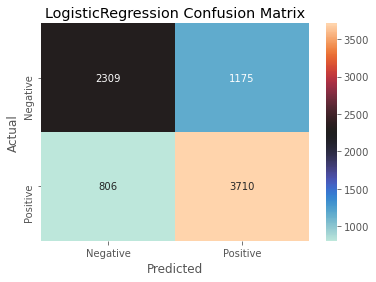

In [41]:
sn.heatmap(confusion_matrix(y_test, pred), annot=True, cmap="icefire",xticklabels=['Negative', 'Positive'],yticklabels=
['Negative', 'Positive'], fmt='g')

sn.color_palette("pastel")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LogisticRegression Confusion Matrix')

# 10FOLD CROSS VALIDATION approach

In [42]:
import matplotlib.pyplot as pyplot
def show_metrics(title,accuracy,precision,recall):
    # joined graph
    pyplot.title(title)
    pyplot.plot(accuracy, label='accuracy')
    pyplot.legend()
    pyplot.plot(precision, label='precision')
    pyplot.legend()
    pyplot.plot(recall, label='recall')
    pyplot.legend(loc="center left")
    pyplot.show()
    
    # seperated graphs
    pyplot.title(f"Accuracy")
    pyplot.plot(accuracy, label='accuracy')
    pyplot.legend()
    pyplot.show()
    pyplot.title(f"Precision")
    pyplot.plot(precision, label='precision')
    pyplot.legend()
    pyplot.show()
    pyplot.title(f"Recall:")
    pyplot.plot(recall, label='recall')
    pyplot.legend()
    pyplot.show()

# logistic regression TFIDF

In [ ]:
from sklearn.model_selection import KFold
lr_tfidf_fold_models = []
lr_tfidf_fold_accuracy = []
lr_tfidf_fold_precision = []
lr_tfidf_fold_recall = []
max_accuracy = 0
lr_tfidf_best_confusion_matrix = []

k_fold = KFold(n_splits=10, shuffle=False)
counter = 1
tfidf_features = tfidfVect.fit_transform(X)
for train_index, validation_index in k_fold.split(tfidf_features):

    logistic_regression = LogisticRegression(random_state=0, max_iter = 1000)
    X_train = tfidf_features[train_index]
    Y_train = y[train_index]
    logistic_regression.fit(X_train,Y_train)

    X_valid = tfidf_features[validation_index]
    Y_valid = y[validation_index]
    Y_valid = Y_valid.values
    predictions = logistic_regression.predict(X_valid)

    lr_tfidf_fold_models.append(logistic_regression)
    lr_tfidf_fold_accuracy.append(accuracy_score(Y_valid, predictions))
    lr_tfidf_fold_precision.append(precision_score(Y_valid, predictions))
    lr_tfidf_fold_recall.append(recall_score(Y_valid, predictions))

    print(f'--------------- Fold {counter} ------------------')
    print(f"Accuracy: {lr_tfidf_fold_accuracy[counter-1]} ")
    print(f"Precision: {lr_tfidf_fold_precision[counter-1]} ")
    print(f"Recall: {lr_tfidf_fold_recall[counter-1]} ")
    if max_accuracy < lr_tfidf_fold_accuracy[counter-1]:
        lr_tfidf_best_confusion_matrix = confusion_matrix(Y_valid,predictions)
        max_accuracy = lr_tfidf_fold_accuracy[counter-1]
    counter+=1


print('-----------------------------------------')
show_metrics('Logistic Regression - TFIDFvectorization',lr_tfidf_fold_accuracy,lr_tfidf_fold_precision,lr_tfidf_fold_recall)

# HEATMAPS

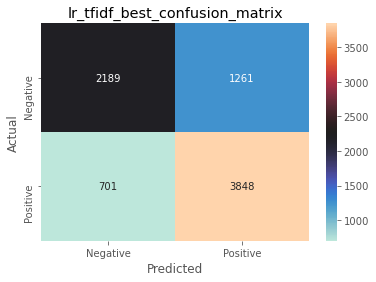

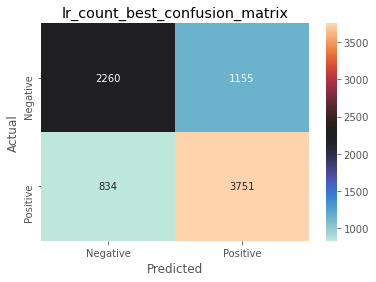

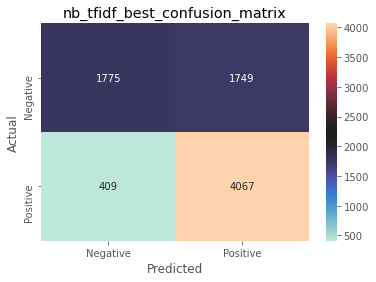

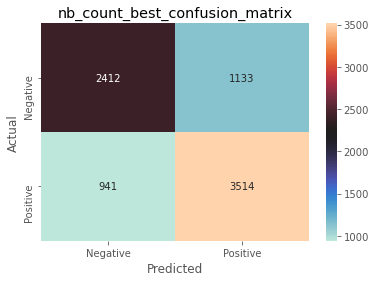

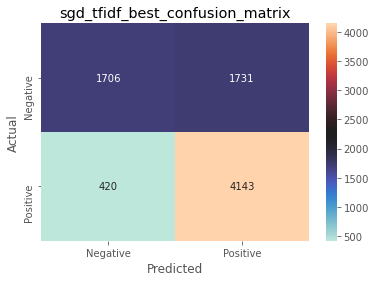

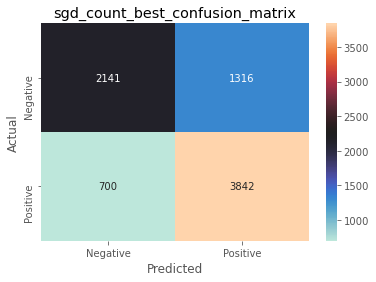

In [53]:
sn.heatmap(lr_tfidf_best_confusion_matrix, annot=True, cmap="icefire",xticklabels=['Negative', 'Positive'],yticklabels=
['Negative', 'Positive'], fmt='g')
sn.color_palette("pastel")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression TFIDF')
plt.show()